На основе материалов <a href="https://matheusfacure.github.io/python-causality-handbook/landing-page.html">учебника</a>, <a href="https://habr.com/ru/company/ru_mts/blog/485980/">статей</a> про uplift на Хабре и <a href="https://arxiv.org/pdf/1906.02120.pdf">статьи</a> о DragonNet.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
import statsmodels.formula.api as smf

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import (
    UpliftTreeClassifier,
    UpliftRandomForestClassifier,
)
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

np.random.seed(123)
sns.set(font_scale=1.3, palette="Set2")

Failed to import duecredit due to No module named 'duecredit'


In [2]:
def elast(data, y, t):
    """Эластичность как коэффициент в линейной регрессии."""

    return np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean())) / np.sum(
        (data[t] - data[t].mean()) ** 2
    )


def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    """Кривая кумулятивной эластичности."""

    size = dataset.shape[0]

    # Сортировка по предсказанию
    ordered_df = dataset.sort_values(prediction, ascending=False)
    ordered_df = ordered_df.reset_index(drop=True)

    # Определение количества бинов
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    return np.array(
        [
            # Вычисление эластичности и домножение на долю объектов
            elast(ordered_df.head(rows), y, t) * (rows / size)
            for rows in n_rows
        ]
    )

# 1. Plug-and-Play Estimators

Условный средний причинно-следственный эффект (CATE) для объекта $x$ для *бинарного тритмента*

$$\tau(x) = \mathsf{E}\left(С_1 - С_0\ | \ X=x\right),$$
где $C_0$ и $C_1$ &mdash; потенциальные исходы.

Если *тритмент вещественный*, то CATE можно определить как
$$\tau(x) = \mathsf{E}\left(\left. \frac{dC_t}{dt}\ \right| \ X=x\right),$$
где $C_t$ &mdash; потенциальный исход при воздействии $t$.

Оценить CATE можно, используя линейную регрессию с учетом взаимодействий между тритментом и признаками

$$y = \theta_0 + \theta_1 t + \theta_2^T X + \theta_3^T (t X).$$

Тогда оценка эластичности (CATE)
$$\widehat{\tau}(x) = \widehat{\theta}_1 + \widehat{\theta}_3^T X$$

---

Обобщим. Рассмотрим произвольную $f$, которую можно построить, например, с помощью бустинга или нейросети.

$$y = f(X, T)$$

Но это модель дает предсказания только таргета $\widehat{y}$, а не самой эластичности $\widehat{\tau}(x)$. В идеале хотелось бы использовать модель, которая вместо минимизации MSE таргета
$$\mathsf{E}\left(Y - \widehat{Y}\right)^2$$

минимизировалы бы MSE эластичности
$$\mathsf{E}\left(\tau(x) - \widehat{\tau}(x)\right)^2 = \mathsf{E}\left(C_1 - C_0 - \widehat{\tau}(x)\right)^2.$$

Но это невозможно напрямую

### Преобразование таргета

Предположим условную независимость тритмента и потенциальных исходов при условии конфаундеров $T \perp C_1, C_0 | X$. При тритмент может назначается не рандомизированно.

Тогда будем прогнозировать следующую величину
$$Z_i = Y_i  \dfrac{T_i - P(X_i)}{P(X_i)(1-P(X_i))},$$
где $P(X_i)$ это propensity score.

Покажем, что такая величина несмещенно оценивает наш CATE
$$\begin{align}
\mathsf{E}\left( Z  \ | \   X=x \right) &= \mathsf{E}\left( \left. Y \dfrac{T - P(X)}{P(X)(1-P(X))}  \ \right| \   X=x \right) \\  \\
&= \mathsf{E}\left( \left. Y T  \dfrac{T - P(X)}{P(X)(1-P(X))} + Y (1-T)  \dfrac{T - P(X)}{P(X)(1-P(X))}  \ \right| \   X=x \right)\\  \\
&= \mathsf{E}\left( \left. C_1  \dfrac{T(1 - P(X))}{P(X)(1-P(X))}   \ \right| \    X=x \right) - \mathsf{E}\left( \left. C_0  \dfrac{(1-T)P(X)}{P(X)(1-P(X))}  \ \right| \   X=x \right)\\  \\
&= \dfrac{1}{P(X)} \mathsf{E}\left( C_1 T  \ | \   X=x \right) - \dfrac{1}{1-P(X)} \mathsf{E}\left( C_0 (1-T)  \ | \    X=x \right)\\  \\
&= \dfrac{1}{P(X)} \mathsf{E}\left( C_1  \ | \   X=x \right)  \mathsf{E}\left( T  \ | \   X=x \right) - \dfrac{1}{1-P(X)} \mathsf{E}\left( C_0  \ | \   X=x \right)  \mathsf{E}\left( (1-T)  \ | \    X=x \right)\\  \\
&= \mathsf{E}\left( C_1  \ | \   X=x \right) - \mathsf{E}\left( C_0  \ | \   X=x \right)\\  \\
&= \tau(x)
\end{align}$$

---

Рассмотрим данные эксперимента с рассылкой электронных письмем об инвестициях, пытаясь мотивировать людей больше инвестировать

In [3]:
email = pd.read_csv("./data/invest_email_biased.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


Разделим на обучение и тест

In [4]:
train, test = train_test_split(email, test_size=0.3)
print(train.shape, test.shape)

(10500, 8) (4500, 8)


Выделим группы признаков и выполним преобразование таргета

In [5]:
y = "converted"  # таргет
T = "em1"  # тритмент
X = ["age", "income", "insurance", "invested"]  # ковариаты и конфаундеры

# Оценим propensity score константой
ps = train[T].mean()

# Преобразование таргета
y_star_train = train[y] * (train[T] - ps) / (ps * (1 - ps))

Обучим модель для полученного таргета и получим предсказания

In [6]:
cate_learner = CatBoostRegressor(
    max_depth=3, min_child_samples=30, n_estimators=50, verbose=False
)
cate_learner.fit(train[X], y_star_train)

test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,-0.061332
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,-0.392025
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.059044
3903,41.0,5802.19,57087.37,20182.20,0,0,1,1,-0.104465
8437,49.1,2202.96,5050.81,9245.88,0,0,1,0,0.079352


Посмотрим на кривую кумулятивного выигрыша

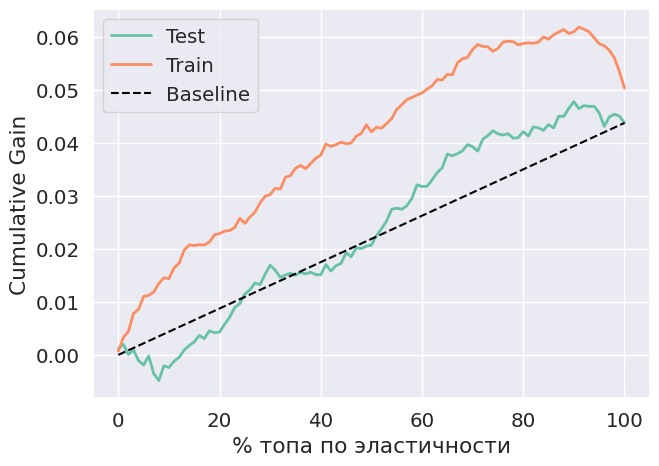

In [7]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(
    train.assign(cate=cate_learner.predict(train[X])),
    "cate",
    y="converted",
    t="em1",
)

plt.plot(gain_curve_test, lw=2, label="Test")
plt.plot(gain_curve_train, lw=2, label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

# 2. Meta Learners

## 2.1 S-Learner 

Будем использовать одну (single, S) модель для оценки
$$M(x, t) = \mathsf{E}(Y \ |\ T=t, X=x),$$
где $X$ &mdash; ковариаты и конфаундеры.

Далее оцениваем CATE
$$\widehat{\tau}(x) = M(x, t=1) - M(x, t=0)$$

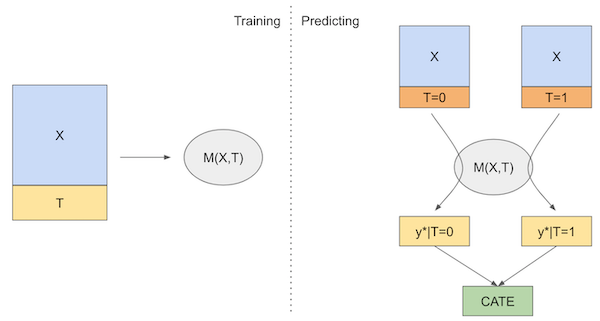

Обучаем модель

In [8]:
s_learner = CatBoostRegressor(
    max_depth=3, min_child_samples=30, n_estimators=50, silent=True
)
s_learner.fit(train[X + [T]], train[y]);

Получаем предсказания для трейна и теста

In [9]:
s_learner_cate_train = train.assign(
    cate=(
        s_learner.predict(train[X].assign(**{T: 1}))
        - s_learner.predict(train[X].assign(**{T: 0}))
    )
)

s_learner_cate_test = test.assign(
    cate=(
        s_learner.predict(test[X].assign(**{T: 1}))
        - s_learner.predict(test[X].assign(**{T: 0}))
    )
)

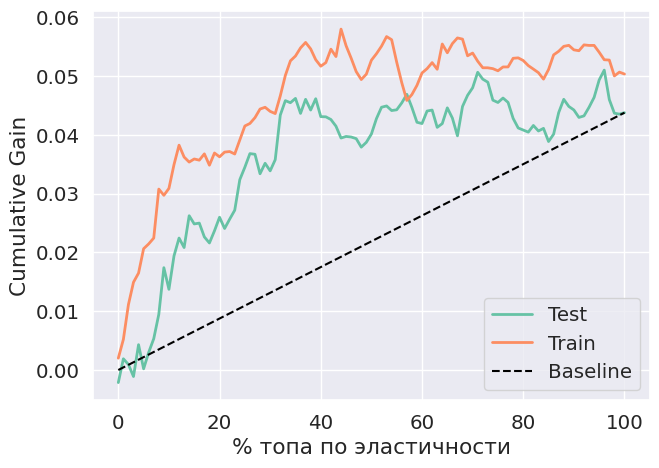

In [10]:
gain_curve_test = cumulative_gain(
    s_learner_cate_test, "cate", y="converted", t="em1"
)
gain_curve_train = cumulative_gain(
    s_learner_cate_train, "cate", y="converted", t="em1"
)

plt.plot(gain_curve_test, lw=2, label="Test")
plt.plot(gain_curve_train, lw=2, label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

Преимущества:
* достаточно простая модель;
* является хорошим бейзлайном;
* может работать с любым типом тритмента.

Недостатки:
* имеет тенденцию сводить эффект тритмента к нулю, например, регуляризация может просто занулить его вес.

## 2.2 T-Learner

Эта модель пытается решить проблему полного отказа от использования тритмента в качестве признака, принудительно сначала разделяясь на нем. 

Будем использовать одну модель для каждого значения тритмента, в бинарном случае это две модели (two, T):
$$M_0(x) = \mathsf{E}(Y \ |\ T=0, X=x)$$
$$M_1(x) = \mathsf{E}(Y \ |\ T=1, X=x)$$

CATE оцениваем как разность
$$\widehat{\tau}(x) = M_1(x) - M_0(x)$$

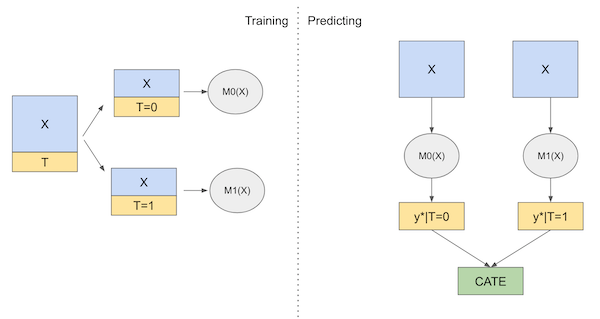

In [11]:
m0 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=30, silent=True
)
m1 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=30, silent=True
)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

t_learner_cate_train = train.assign(cate=m1.predict(train[X]) - m0.predict(train[X]))
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

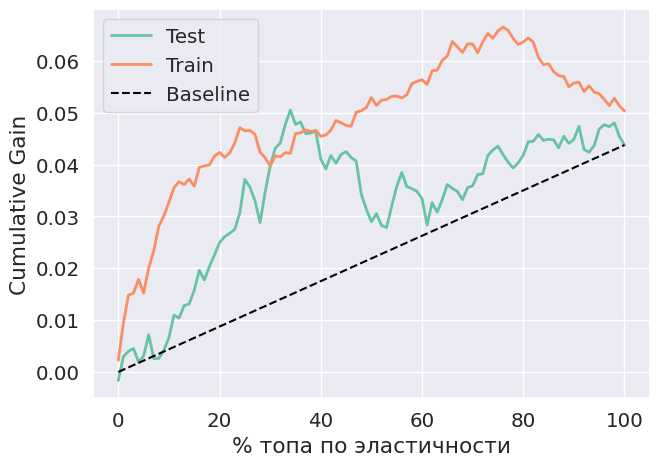

In [12]:
gain_curve_test = cumulative_gain(
    t_learner_cate_test, "cate", y="converted", t="em1"
)
gain_curve_train = cumulative_gain(
    t_learner_cate_train, "cate", y="converted", t="em1"
)

plt.plot(gain_curve_test, lw=2, label="Test")
plt.plot(gain_curve_train, lw=2, label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

Недостатки:
* работает только с категориальным тритмент;
* если размеры выборок сильно отличаются (частый случай &mdash; тестовая выборка маленькая), то модели скорее всего будут иметь разную сложность. Например, одна линейная, другая нет. В таком случае могут возникать довольно сильные смещения.

В примере ниже модель для тестовой выборки простая в силу малого количества элементов в тесте, и она показывает некоторый наклон. Тем не менее, истинная зависимость постоянная. В контрольной выборке сильно больше элементов, там используется более сложная модель, которая правильно приближает истинную зависимость. Но итоговый результат при оценке CATE из-за ошибки первой модели получается кусочно-линейным, а не кусочно-постоянным.


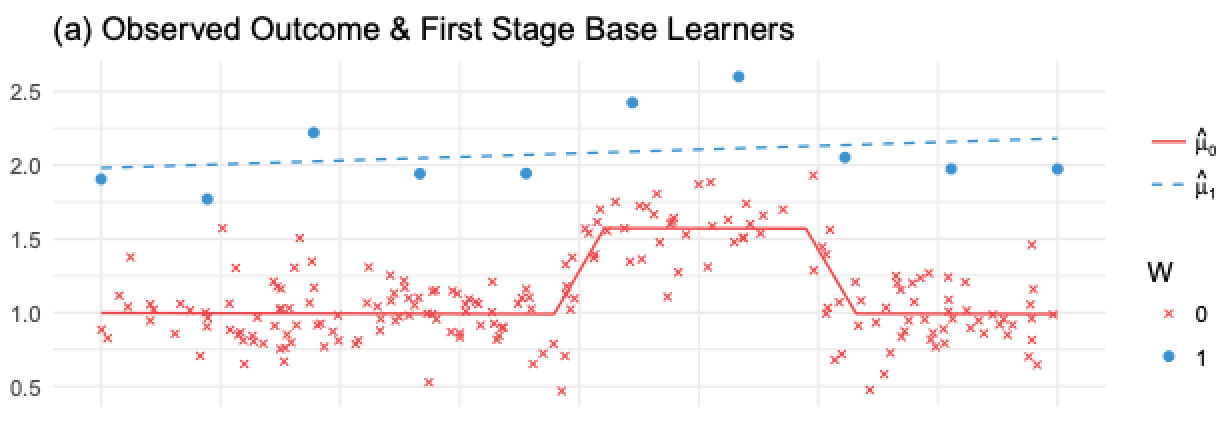


## 2.3 X-Learner

Модель X-Learner состоит из двух этапов и модели propensity score. 

Первый этап идентичен T-learner
$$M_0(x) = \mathsf{E}(Y \ |\ T=0, X=x)$$
$$M_1(x) = \mathsf{E}(Y \ |\ T=1, X=x)$$

На втором этапе оценим контрафактивные исходы для обучающей выборки с помощью построенных ранее моделей
$$\widehat{\tau}(x, t=0) = M_1(x) - C_0$$
$$\widehat{\tau}(x, t=1) = C_1 - M_0(x)$$

Здесь были использованы наблюдаемые потенциальные исходы и предсказания контрафактивных.
Теперь у нас есть оценки CATE, но только для обучающей выборки.

Затем обучим еще две модели, чтобы предсказать эти эффекты
$$\widehat{H}_0(x) = \mathsf{E}(\widehat{\tau}(x, t=0) \ |\ T=0, X=x)$$
$$\widehat{H}_1(x) = \mathsf{E}(\widehat{\tau}(x, t=1) \ |\ T=1, X=x)$$

Наконец, оцениваем СATE как взвешенную комбинацию построенных моделей с весами propensity score
$$\widehat{\tau}(x) = \widehat{H}_0(x)\widehat{P}(x) + \widehat{H}_1(x)\left(1-\widehat{P}(x)\right)$$

---

**Идея:**

Тут красные точки $\widehat{\tau}(x, t=0)$ построены с использованием простой модели $M_1(x)$, которая допустила смещение. Синие точки $\widehat{\tau}(x, t=1)$ предсказаны правильно, потому как модель $M_0(x)$ несмещенная
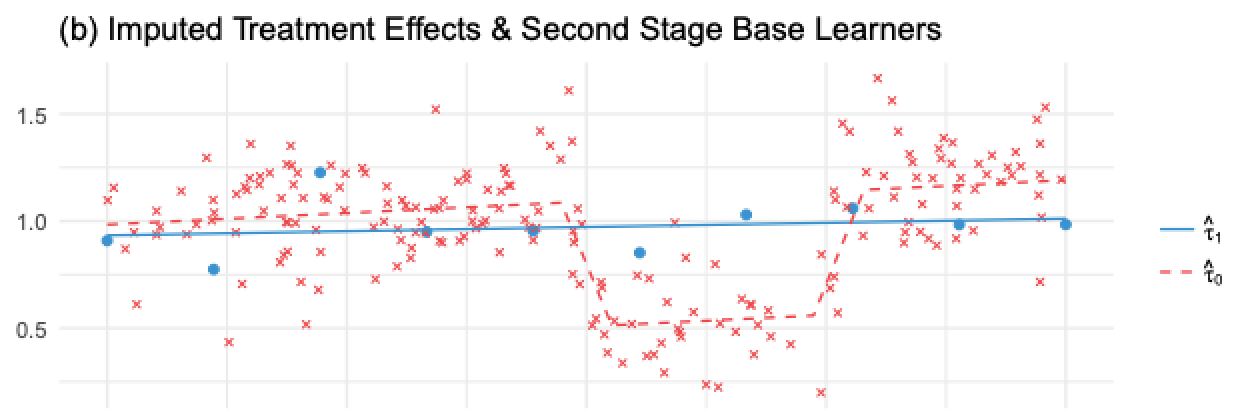

Тем самым модель $\widehat{H}_1(x)$ оказывается несмещенной, а модель $\widehat{H}_0(x)$ &mdash; смещенной. В таком случае мы их усредним с весам, пропорционально propensity score. Поскольку тестовых объектов мало, то $\widehat{P}(x)$ обычно будет небольшой, и мы чаще будем смотреть на $\widehat{H}_1(x)$.
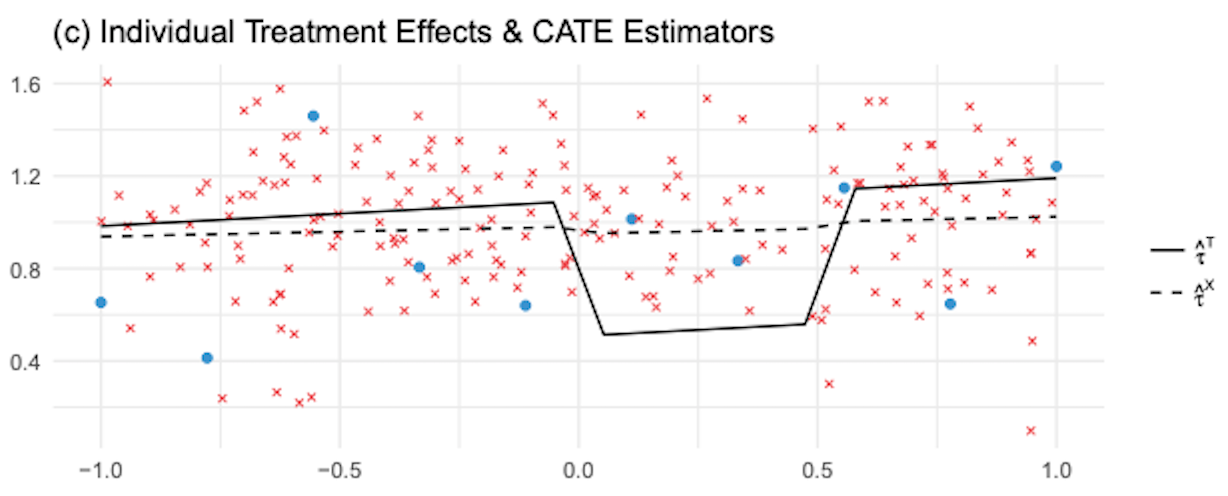

Схема модели

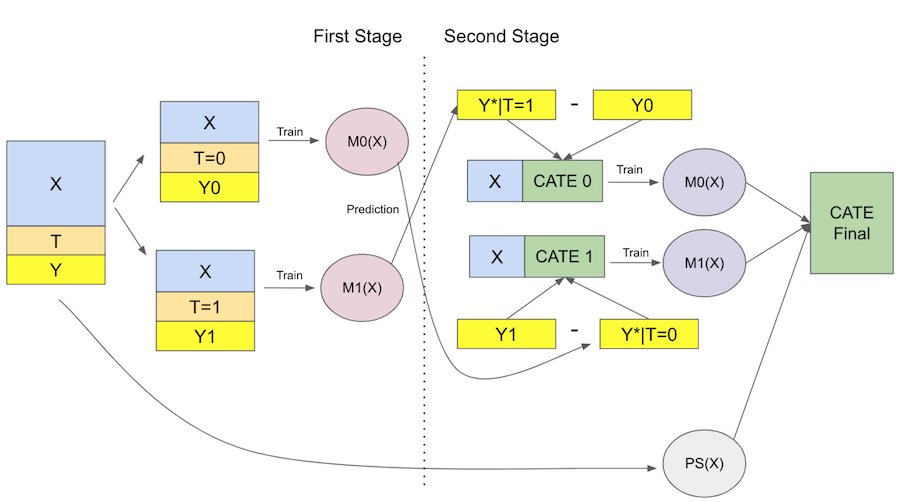

Обучим модели первого этапа

In [13]:
m0 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=30, silent=True
)
m1 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=30, silent=True
)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

Обучим модели второго этапа

In [14]:
d_train = np.where(
    train[T] == 0,
    m1.predict(train[X]) - train[y],
    train[y] - m0.predict(train[X]),
)

mx0 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=1000, silent=True
)
mx1 = CatBoostRegressor(
    max_depth=1, min_child_samples=30, n_estimators=1000, silent=True
)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T] == 0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T] == 1]);

Обучим модель propensity score, получим предсказания и соединим их по формуле

In [15]:
# propensity score
g = LogisticRegression(solver="lbfgs", penalty=None)
g.fit(train[X], train[T])

ps_train = g.predict_proba(train[X])[:, 1]
ps_test = g.predict_proba(test[X])[:, 1]

# Оцениваем CATE
x_cate_train = (1 - ps_train) * mx0.predict(train[X]) + ps_train * mx1.predict(
    train[X]
)

x_cate_test = test.assign(
    cate=(1 - ps_test) * mx0.predict(test[X]) + ps_test * mx1.predict(test[X])
)

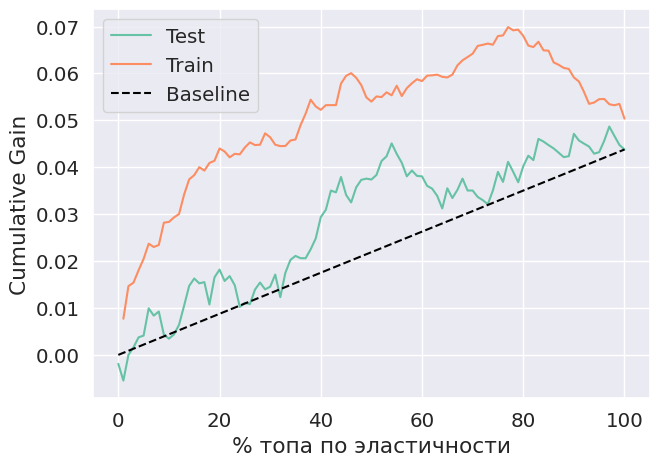

In [16]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(
    train.assign(cate=x_cate_train), "cate", y="converted", t="em1"
)

plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

## 2.4 R-Learner

Вернемся к данным о продажах мороженного

In [17]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


### Преобразование Frisch-Waugh-Lovell

Пусть есть линейная регрессия на двух наборах признаков $X_1$ и  $X_2$
$$\widehat{Y} =  X_1 \widehat{\theta}_1 + X_2 \widehat{\theta}_2.$$

Утверждается, что оценку $\widehat{\theta}_1$ можно получить следующим образом
 
1. Построить линейную регрессию $\widehat{y}^* = \widehat{\gamma}_1 X_2$;
2. Построить линейную регрессию $\widehat{X}_1 = \widehat{\gamma}_2 X_2$;
3. Посчитать остатки $\widetilde{X}_1 = X_1 - \widehat{X}_1$ и $\widetilde{y} = y - \widehat{y}^*$;
4. Построить линейную регрессию $\widetilde{y} = \widehat{\theta}_1 \widetilde{X}_1$.



In [18]:
# Первая модель
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()

# Вторая модель
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

# Модель по остаткам
smf.ols(
    "sales_res~price_res",
    data=train.assign(sales_res=my.resid, price_res=mt.resid),
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.14e-13,0.111,-3.74e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


Для сравнения обучим полную модель и сравним результаты

In [19]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475419

Иначе говоря, мы сделали следующую модель
$$Y - (Y \sim X)\ \ \sim\ \ T - (T \sim X).$$


Или можно записать так
$$Y - \mathsf{E}(Y | X) = \tau \cdot \big[ T - \mathsf{E}(T | X) \big].$$

### Обобщение Frisch-Waugh-Lovell

Давайте на первых двух шагах использовать произвольные модели
$$Y_i - \widehat{M}_y(X_i)
= \tau \cdot (T_i - \widehat{M}_t(X_i))$$
где $\widehat{M}_y(X_i)$
 оценивает $\mathsf{E}(Y|X)$ и $\widehat{M}_t(X_i)$
 оценивает $\mathsf{E}(T|X)$.
 
Во избежание переобучения такие модели необходимо обучать с помощью кросс-валидации

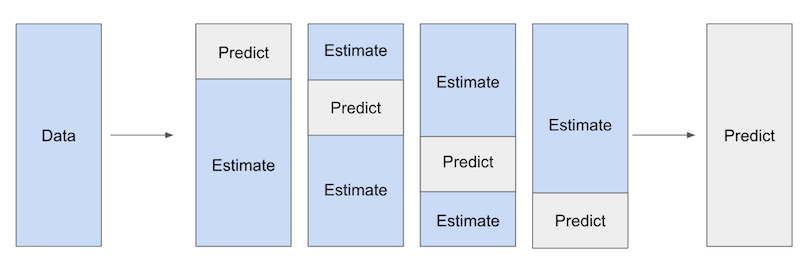

По результатам этих моделей обучим линейную модель
$$\tilde{Y} = \alpha + \tau \tilde{T}.$$

---

Обучаем первую модель предсказывать тритмент

In [20]:
y = "sales"  # таргет
T = "price"  # тритмент
X = ["temp", "weekday", "cost"]  # ковариаты и конфаундеры

debias_m = CatBoostRegressor(max_depth=3, silent=True)
price_pred = cross_val_predict(debias_m, train[X], train[T], cv=5)

train_pred = train.assign(price_res=train[T] - price_pred + train[T].mean())

Обучаем вторую модель предсказывать таргет

In [21]:
denoise_m = CatBoostRegressor(max_depth=3, silent=True)
sales_pred = cross_val_predict(denoise_m, train[X], train[y], cv=5)

train_pred = train_pred.assign(sales_res=train[y] - sales_pred + train[y].mean())

Теперь обучаем линейную модель на остатках предыдущих моделей

In [22]:
final_model = smf.ols(formula="sales_res ~ price_res", data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.3801,0.440,510.201,0.000,223.518,225.242
price_res,-3.8938,0.071,-55.005,0.000,-4.033,-3.755


Видим отрицательный эффект роста цены, что и следовало ожидать. Но это только ATE.

Сравним также с простой линейной регрессией продаж по цене

In [23]:
final_model = smf.ols(formula="sales ~ price", data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


На самом деле на втором этапе можно использовать более сложную линейную модель, предполагая зависимость
$$Y - {M}_y(X)
= \tau(X) \cdot (T - {M}_t(X)) + \varepsilon.$$

Тем самым мы обучаем линейную модель
$$\widetilde{Y} = \alpha + \beta_1 \widetilde{T} + \beta_2^T (X \widetilde{T})$$


Такая модель уже позвояет CATE

In [24]:
final_model_cate = smf.ols(
    formula="sales_res ~ price_res * (temp + C(weekday) + cost)",
    data=train_pred,
).fit()

cate_test = test.assign(
    cate=final_model_cate.predict(test.assign(price_res=1))
    - final_model_cate.predict(test.assign(price_res=0))
)

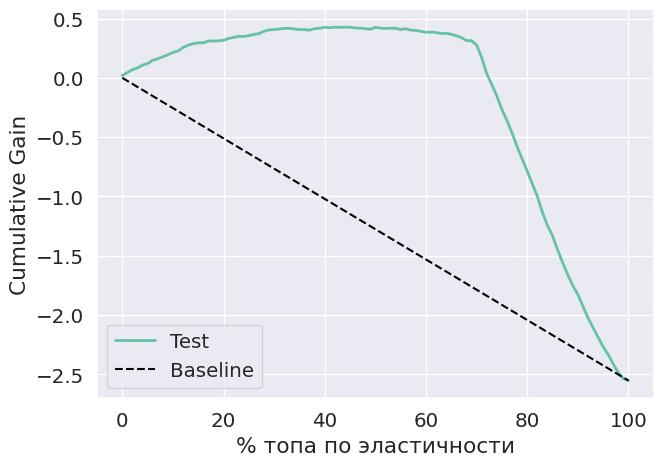

In [25]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)

plt.plot(gain_curve_test, lw=2, label="Test")
plt.plot(
    [0, 100],
    [0, elast(test, y, T)],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

## 2.5 DR-Learner (Doubly Robust)

Разделим датасет на две части:
$$D_1:\ \ X_1,\ T_1,\ Y_1$$
$$D_2:\ \ X_2,\ T_2,\ Y_2$$

**Шаг 1.**

1. Обучаем модель propensity score $\widehat{P}(x)$ по датасету $D_1$.
2. Обучаем модели $\widehat{M}_0(x)$ и $\widehat{M}_1(x)$ предсказывать потенциальные исходы по датасету $D_1$, разделяя его на тритмент/контроль.

**Шаг 2.**

1. Определяем псевдо-таргет
$$Z_i = \frac{T_i - \widehat{P}(X_i)}{\widehat{P}(X_i)\left( 1-\widehat{P}(X_i) \right)} \cdot \left( Y_i - \widehat{M}_{T_i}(X_i) \right) + \widehat{M}_1(X_i) - \widehat{M}_0(X_i)$$
2. Обучаем модель $\widehat{\tau}(x)$ по датасету $D_2$ предсказывать CATE, используя в качестве таргета построенный псевдо-таргет $Z_i$.

**Шаг 3 (опционально).**

1. Повторяем шаги 1-2 меняя датасеты местами: $(D_2, D_1)$.
2. Итоговая оценка CATE получается усреднением результатов двух моделей $\widehat{\tau}(x)$.

---

Возьмем первые данные

In [26]:
email = pd.read_csv("./data/invest_email_biased.csv")
train, test = train_test_split(email, test_size=0.3)
y = "converted"  # таргет
T = "em1"  # тритмент
X = ["age", "income", "insurance", "invested"]  # ковариаты и конфаундеры

Делим обучающую часть на две

In [27]:
train_first, train_second = train_test_split(train, test_size=0.5)

Применяем пайплайн шагов 1-2

In [28]:
def one_variant(train_first, train_second, X, T, y):
    m0 = CatBoostRegressor(
        max_depth=1, min_child_samples=30, n_estimators=30, silent=True
    )
    m1 = CatBoostRegressor(
        max_depth=1, min_child_samples=30, n_estimators=30, silent=True
    )

    m0.fit(train_first.query(f"{T}==0")[X], train_first.query(f"{T}==0")[y])
    m1.fit(train_first.query(f"{T}==1")[X], train_first.query(f"{T}==1")[y])

    propscore_model = LogisticRegression()
    propscore_model.fit(train_first[X], train_first[T])

    ps = propscore_model.predict_proba(train_second[X])[:, 1]
    m0_pred = m0.predict(train_second[X])
    m1_pred = m1.predict(train_second[X])

    z_target = (
        (train_second[T] - ps)
        / (ps * (1 - ps))
        * (
            train_second[y]
            - (m0_pred * (1 - train_second[T]) + m1_pred * train_second[T])
        )
        + m1_pred
        - m0_pred
    )

    tau_model = CatBoostRegressor(
        max_depth=1, min_child_samples=30, n_estimators=30, silent=True
    )
    tau_model = tau_model.fit(train_second[X], z_target)
    return tau_model

In [29]:
tau1 = one_variant(train_first, train_second, X, T, y)
tau2 = one_variant(train_second, train_first, X, T, y)

Считаем предсказания и строим кривую качества

In [30]:
dr_cate_train = (tau1.predict(train[X]) + tau2.predict(train[X])) / 2
dr_cate_test = test.assign(cate=(tau1.predict(test[X]) + tau2.predict(test[X])) / 2)

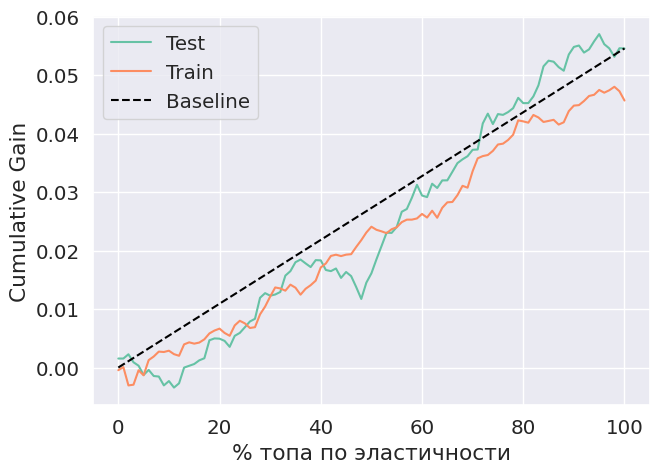

In [31]:
gain_curve_test = cumulative_gain(dr_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(
    train.assign(cate=dr_cate_train), "cate", y="converted", t="em1"
)

plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

# 3. Другие интересные модели
## 3.1 Многоклассовая модель

Так как мы можем взаимодействовать с клиентами $ T_i = \{0, 1\} $ и наблюдать их реакцию $ Y_i = \{0, 1\} $, то разделим их на 4 непересекающихся класса:

1. Клиент выполнил целевое действие и мы с ним не коммуницировали (**Control Responder — CR**): $Y_i = 1, T_i = 0$
2. Клиент не выполнил целевое действие и мы с ним не коммуницировали (**Control Non-Responder — CN**): $Y_i = 0, T_i = 0 $
3. Клиент выполнил целевое действие и мы с ним коммуницировали (**Treated Responder — TR**): $Y_i = 1, T_i = 1$
4. Клиент не выполнил целевое действие и мы с ним коммуницировали (**Treated Non-Responder — TN**): $Y_i = 0, T_i = 1$

Обучим классификатор на 4 вышеупомянутых класса, причем модель должна предсказывать вероятности классов.

Заметим, что можно привести следующую интерпретацию классов

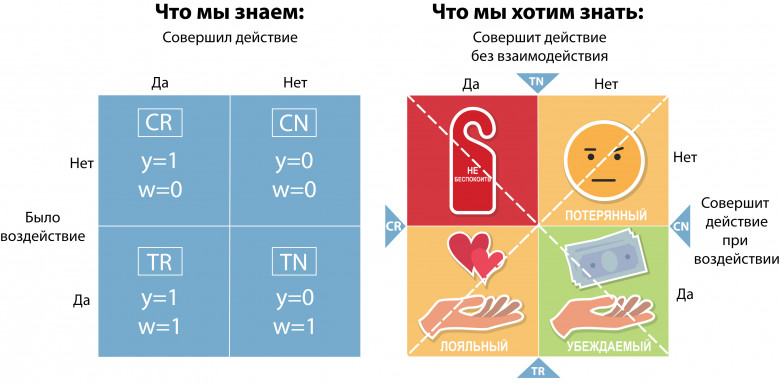

1. Так как мы не знаем, выполнил бы **CR** клиент целевое действие при нашем воздействии, то он относится либо к *не беспокоить*, либо к *лояльным* клиентам. 
2. Среди **CN** клиентов могут быть как *потерянные*, так и *убеждаемые* типы клиентов
3. Среди **TR** клиентов могут быть как *убеждаемые*, так и *лояльные* типы клиентов
4. Среди **ТN** клиентов могут быть как *не беспокоить*, так и *потерянные* типы клиентов

Тогда в качестве оценки реакции клиента на взаимодействие возьмем сумму вероятностей тех классов, где есть убеждаемые клиенты, и вычтем сумму вероятностей тех классов, где клиенты, которых не беспокоить.

$$\widehat{\tau}(x) = \left[ \frac{\widehat{\mathsf{P}}( TR\ |\ X=x)}{r_1} + \frac{\widehat{\mathsf{P}}( CN\ |\ X=x)}{r_0} \right] - \left[ \frac{\widehat{\mathsf{P}}( TN\ |\ X=x)}{r_1} + \frac{\widehat{\mathsf{P}}( CR\ |\ X=x)}{r_0} \right], $$

где $r_1, r_0$ &mdash; доля клиентов в тестовой и контрольной группах соответственно, а $\widehat{\mathsf{P}}$ &mdash; предсказания вероятностей обученным классификатором.

В результате мы получим не сам CATE, а некоторую величину, определяющую *порядок*. Чем эта величина больше, тем выше шанс положительного эффекта от взаимодействия с данным клиентом. Обычно большие положительные значения оценки соответствуют убеждаемым клиентам, большие отрицательные &mdash; клиентам типа "не беспокоить", а посередите потерянные и лояльные клиенты.

## 3.2 Causal trees

Дерево строится так, чтобы максимизировать расстояние (дивергенцию) между распределениями целевой переменной у контрольной и целевой групп. 

$$H = D_{after}(\mathsf{P}_0, \mathsf{P}_1) - D_{before}(\mathsf{P}_0, \mathsf{P}_1),$$

где $\mathsf{P}_0, \mathsf{P}_1$ &mdash; распределения таргета в контрольной и целевой группах, а $D$ &mdash; расстояние между распределениями:
* дивергенция Кульбака-Лейблера;
* Евклидово расстояние по вероятностям;
* расстояние хи-квадрат.

В листе записываем оценку ATE по подвыборке, которая в него попала

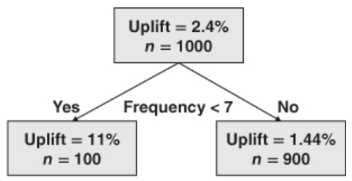


Сгенерируем данные

In [32]:
df, x_names = make_uplift_classification(
    treatment_name=["control", "treatment"],
)
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,x10_irrelevant,conversion,treatment_effect
0,treatment,-0.090262,2.212644,0.465246,1.234381,3.605371,0.263686,-1.391989,-0.748999,0.995666,-0.559627,1,0
1,treatment,1.296345,1.126756,-0.390840,2.816444,0.878906,-0.495582,0.105605,-2.181952,-0.904848,-0.718033,1,0
2,control,-1.777419,-0.746741,-2.206541,-0.399638,3.986540,-1.138827,-0.765340,-0.113769,-1.411139,0.921662,0,0
3,control,-2.356745,-1.958517,-0.765114,3.736352,1.801522,1.317978,-1.095714,0.729767,2.489876,0.090676,0,0
4,control,0.111738,-1.506129,0.095115,0.068337,1.294267,-0.178877,-0.488089,0.257341,0.210113,2.235305,1,0


Переименуем столбцы

In [33]:
x_names_new = ["feature_%s" % (i) for i in range(len(x_names))]
rename_dict = {x_names[i]: x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

df.head()

,treatment_group_key,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,conversion,treatment_effect
0,treatment,-0.090262,2.212644,0.465246,1.234381,3.605371,0.263686,-1.391989,-0.748999,0.995666,-0.559627,1,0
1,treatment,1.296345,1.126756,-0.390840,2.816444,0.878906,-0.495582,0.105605,-2.181952,-0.904848,-0.718033,1,0
2,control,-1.777419,-0.746741,-2.206541,-0.399638,3.986540,-1.138827,-0.765340,-0.113769,-1.411139,0.921662,0,0
3,control,-2.356745,-1.958517,-0.765114,3.736352,1.801522,1.317978,-1.095714,0.729767,2.489876,0.090676,0,0
4,control,0.111738,-1.506129,0.095115,0.068337,1.294267,-0.178877,-0.488089,0.257341,0.210113,2.235305,1,0


Посмотрим на конверсию по группам

In [34]:
df.pivot_table(
    values="conversion",
    index="treatment_group_key",
    aggfunc=[np.mean, np.size],
    margins=True,
)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.483,1000
treatment,0.517,1000
All,0.500,2000


Разделим данные на две части

In [35]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

Обучим дерево для предсказания аплифта

In [36]:
uplift_model = UpliftTreeClassifier(
    max_depth=4,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="KL",
    control_name="control",
)

uplift_model.fit(
    df_train[x_names].values,
    treatment=df_train["treatment_group_key"].values,
    y=df_train["conversion"].values,
)

Можем получить дерево в текстовом виде

In [37]:
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

feature_8 >= -0.08610034239594319?
yes -> feature_6 >= 0.48490085427165724?
		yes -> [0.5258620689655172, 0.4838709677419355]
		no  -> feature_4 >= 1.0067093669584843?
				yes -> [0.488, 0.5483870967741935]
				no  -> [0.4198473282442748, 0.5771812080536913]
no  -> feature_1 >= -0.12986865811864415?
		yes -> [0.3805970149253731, 0.5]
		no  -> feature_6 >= -0.013149938530788266?
				yes -> [0.5073529411764706, 0.4722222222222222]
				no  -> [0.5769230769230769, 0.41935483870967744]


А можем просто визуализировать дерево

Информация, которая печатается в узлах:

* `impurity`: значение для функции потерь

* `total_sample`: общий размер выборки в этом узле

* `group_sample`: размеры групп

* `uplift score`: эффект между группами для данного подмножества объектов

* `p_value` для оценки стат. значимости эффекта

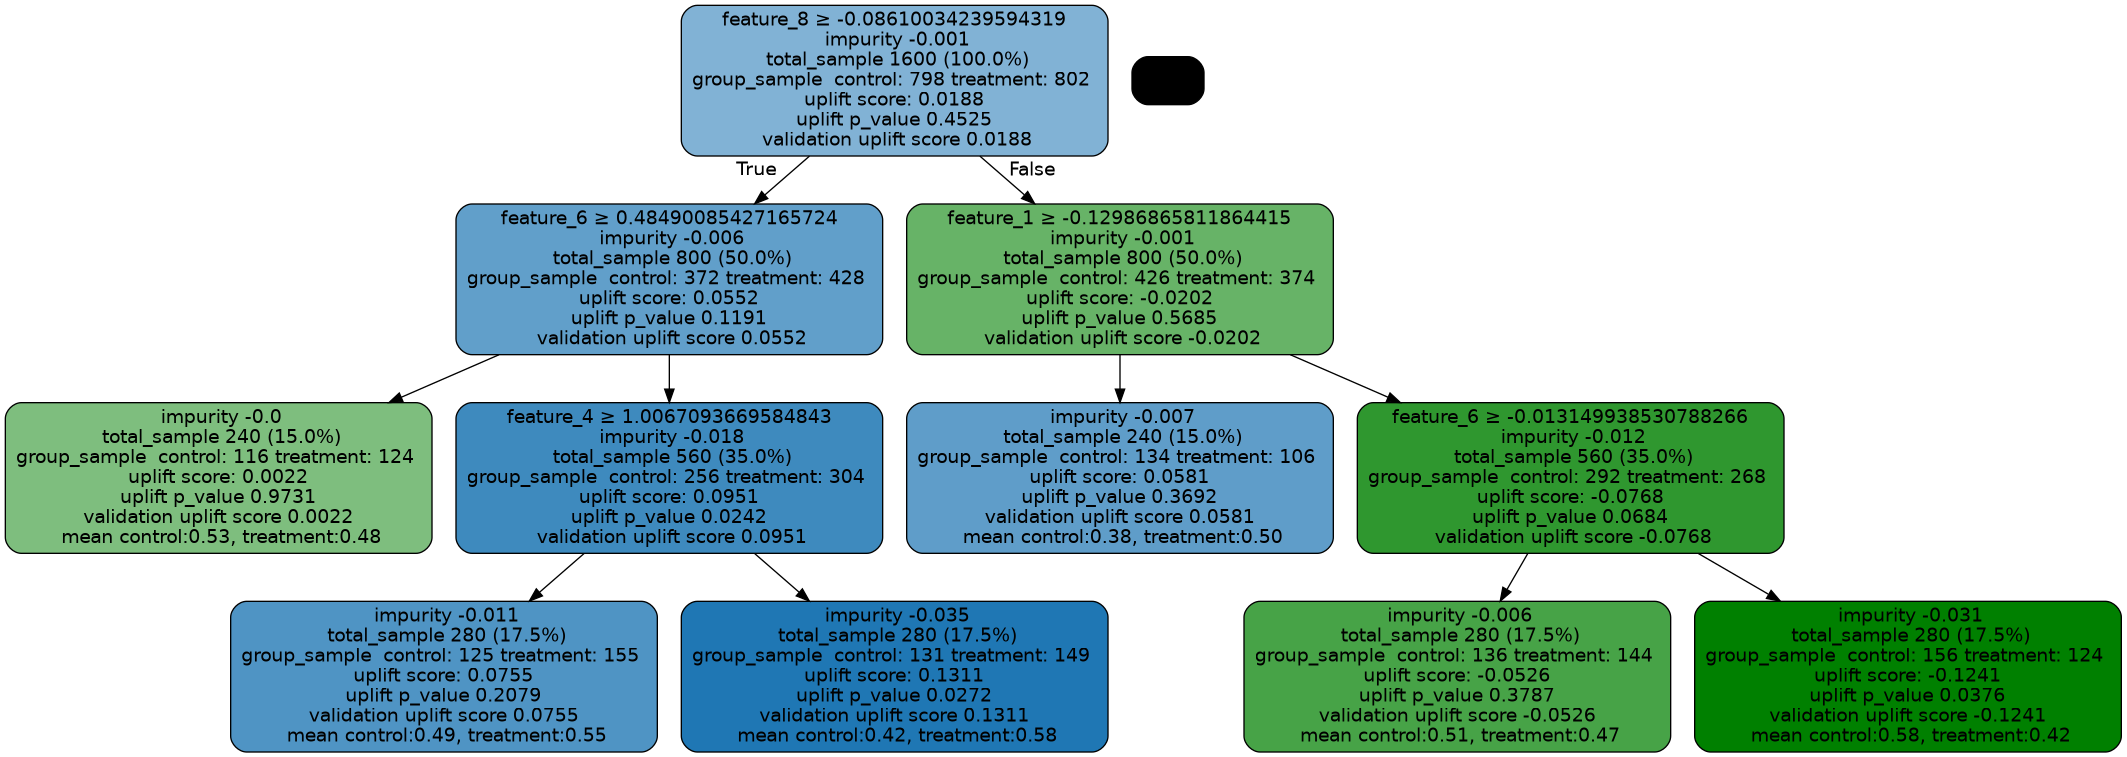

In [38]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, x_names)
Image(graph.create_png())

Можем закинуть в построенное дерево валидационную выборку и посмотреть на результат

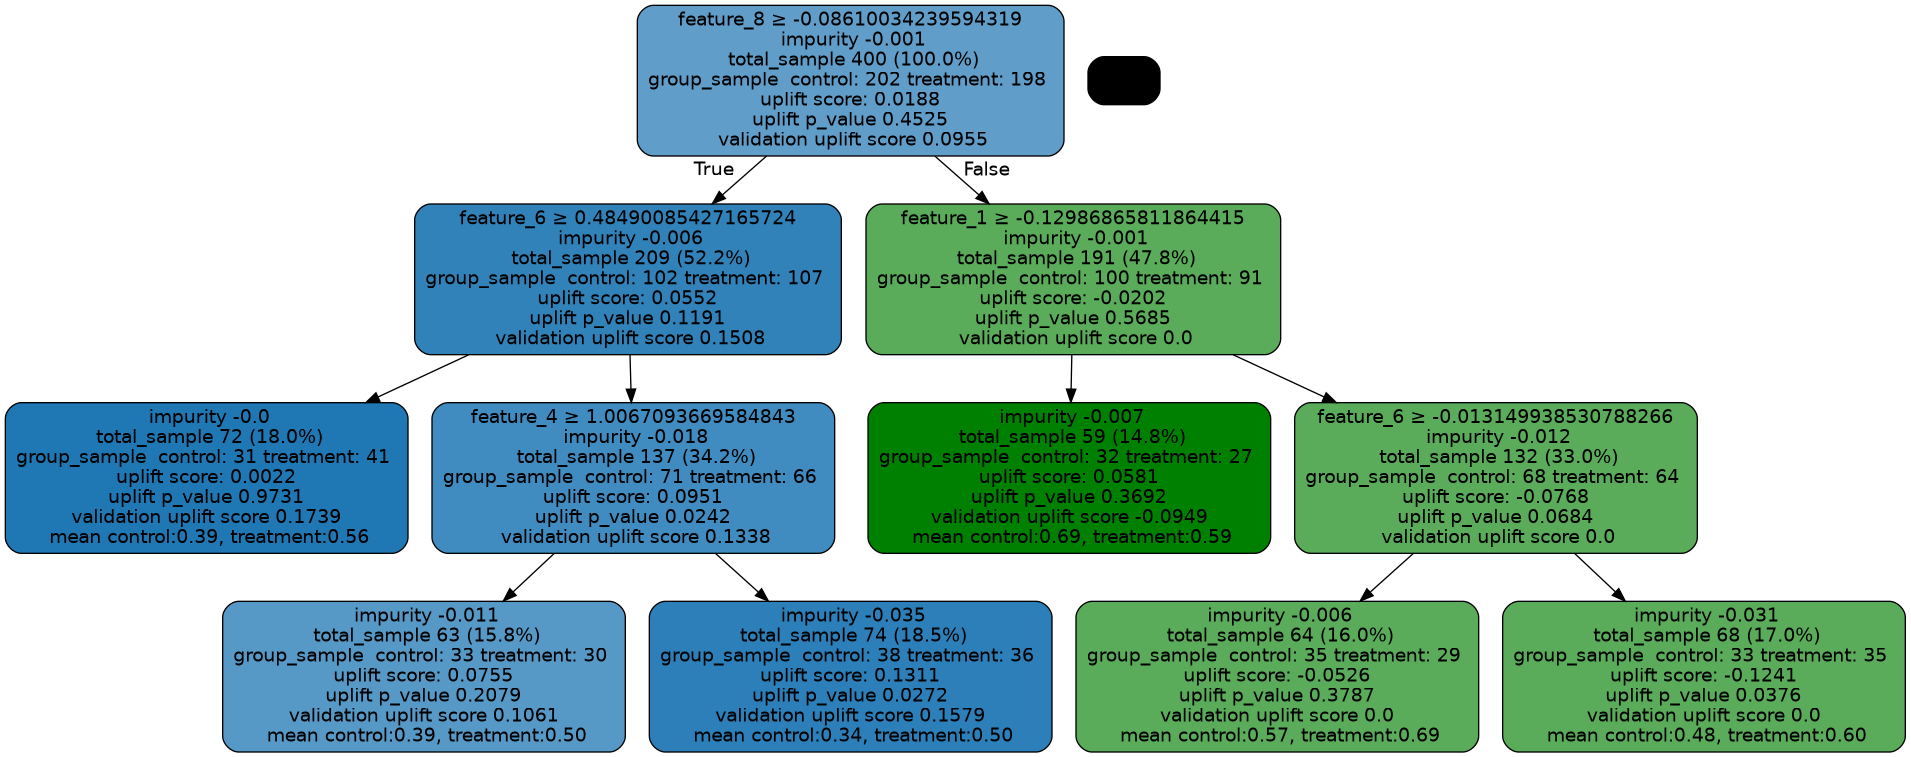

In [39]:
uplift_model.fill(
    X=df_test[x_names].values,
    treatment=df_test["treatment_group_key"].values,
    y=df_test["conversion"].values,
)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, x_names)
Image(graph.create_png())

Аналогично можем строить случайный лес из аплифтовых деревьев

In [40]:
uplift_model = UpliftRandomForestClassifier(
    n_estimators=5,
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="KL",
    control_name="control",
)

uplift_model.fit(
    df_train[x_names].values,
    treatment=df_train["treatment_group_key"].values,
    y=df_train["conversion"].values,
)

Извлекать и визуализировать конкретные деревья

In [41]:
uplift_tree = uplift_model.uplift_forest[0]
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

feature_8 >= -0.10275353592577242?
yes -> feature_6 >= 0.5202853263052453?
		yes -> [0.5378151260504201, 0.48360655737704916]
		no  -> feature_0 >= 0.06439938063254069?
				yes -> [0.7288135593220338, 0.8159509202453987]
				no  -> [0.15625, 0.3684210526315789]
no  -> feature_2 >= 0.035371655913938815?
		yes -> [0.5576923076923077, 0.387434554973822]
		no  -> [0.4511627906976744, 0.5271739130434783]


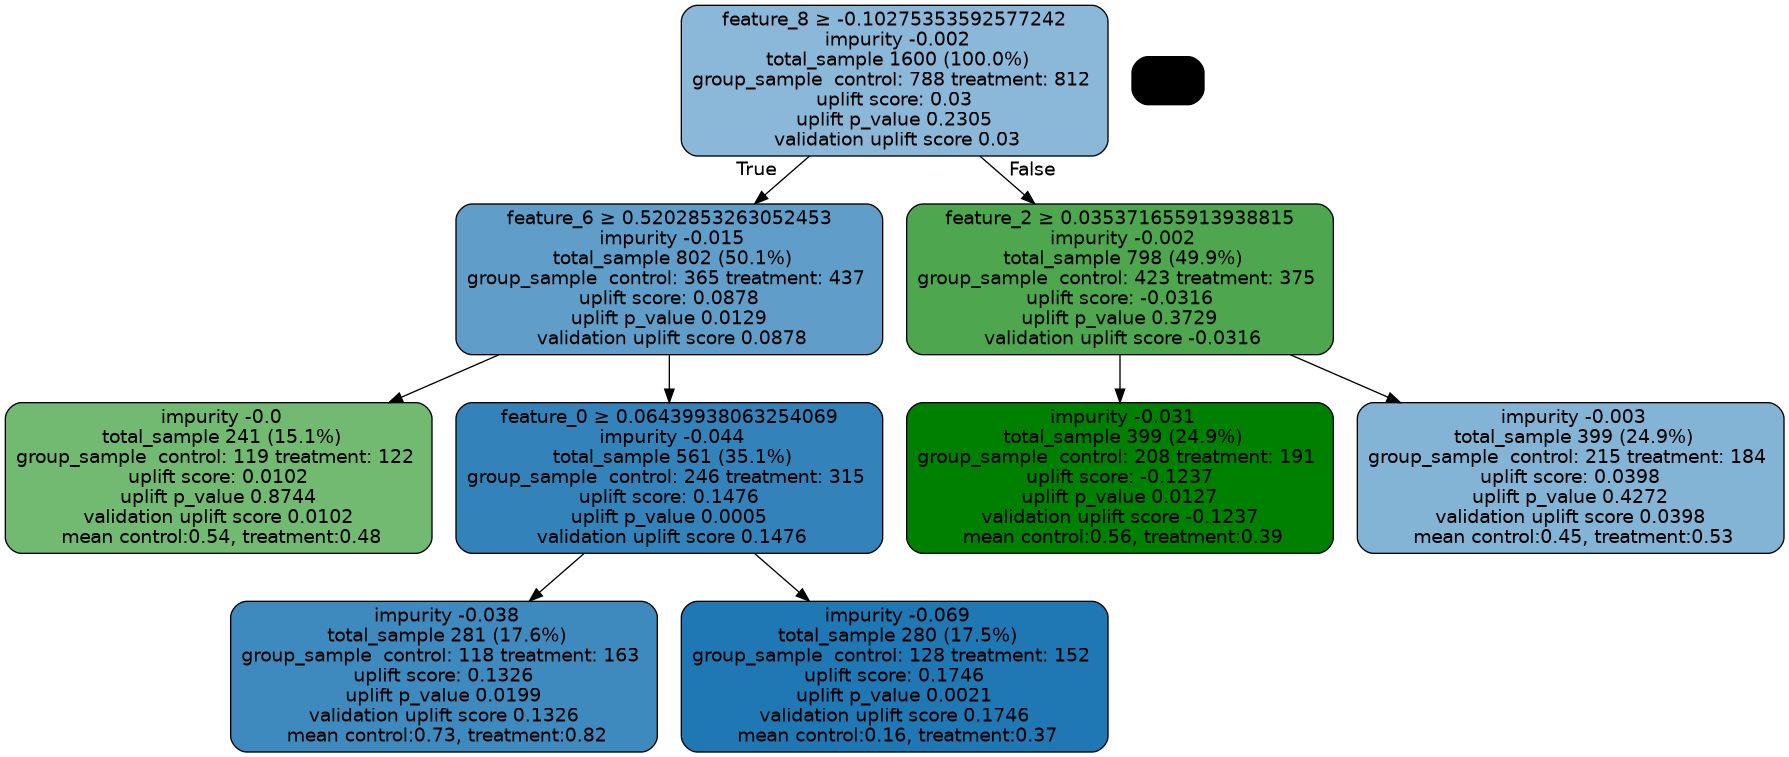

In [42]:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, x_names)
Image(graph.create_png())

Важность признаков

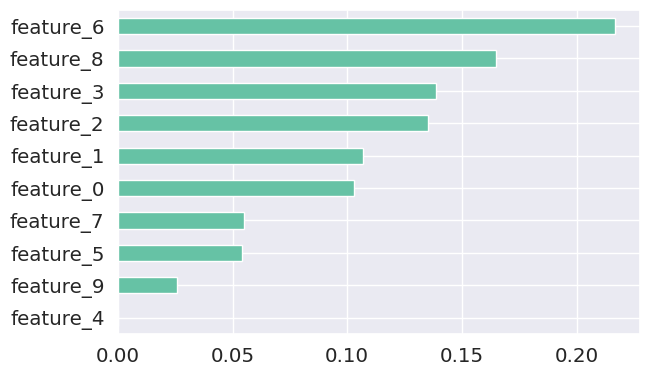

In [43]:
pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(
    kind="barh", figsize=(6, 4)
);

Извлекаем предсказания аплифта и построим кривую качества

In [44]:
df_test_uplift = df_test.assign(cate=uplift_model.predict(df_test[x_names].values))
df_train_uplift = df_train.assign(
    cate=uplift_model.predict(df_train[x_names].values)
)

df_test_uplift["T"] = (df_test_uplift["treatment_group_key"] == "treatment").astype(
    int
)
df_train_uplift["T"] = (
    df_train_uplift["treatment_group_key"] == "treatment"
).astype(int)

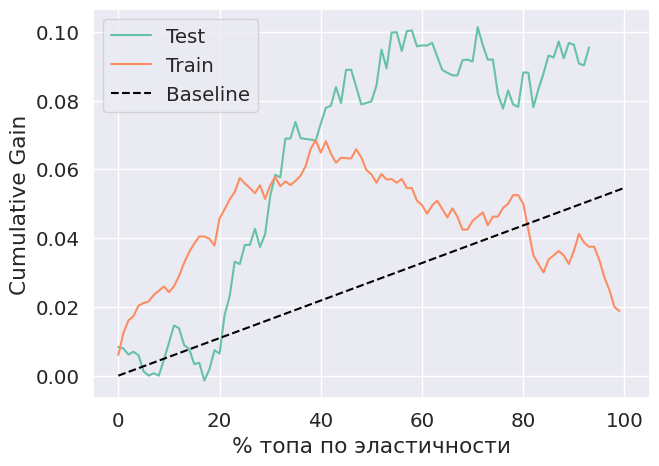

In [45]:
gain_curve_test = cumulative_gain(df_test_uplift, "cate", y="conversion", t="T")
gain_curve_train = cumulative_gain(df_train_uplift, "cate", y="conversion", t="T")

plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot(
    [0, 100],
    [0, elast(test, "converted", "em1")],
    linestyle="--",
    color="black",
    label="Baseline",
)
plt.xlabel("% топа по эластичности")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

## 3.3 DragonNet

<a href="https://arxiv.org/pdf/1906.02120.pdf">Статья</a> (2019)

<a href="https://paperswithcode.com/sota/causal-inference-on-ihdp">IHDP Benchmark</a>: **2 место** по точности среди моделей оценки ATE (апрель 2025).


Вход: $X$ &mdash; ковариаты, конфаундеры, инструменты

Выход:
* $Q_\theta(0, X) = \widehat{\mathsf{E}}(C_0\ |\ X)$ &mdash; оценка потенциального исхода при $T=0$;
* $Q_\theta(1, X) = \widehat{\mathsf{E}}(C_1\ |\ X)$ &mdash; оценка потенциального исхода при $T=1$; 
* $g_\theta(X) = \widehat{\mathsf{P}}(T=1\ |\ X)$ &mdash; оценка propensity score.


Схема сети
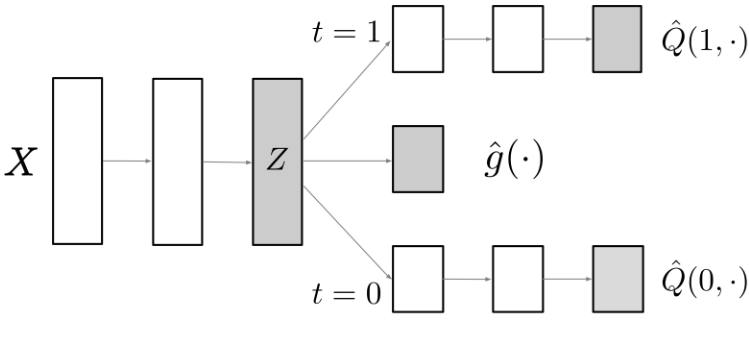

Признаки $X$ сначала за несколько слоев (не обязательно 2) преобразуются в некоторое векторное представление $Z$. Затем из $Z$ отдельно получается каждый из потенциальных исходов с помощью нескольких скрытых слоев. Однако, для получения оценки propensity score из $Z$ используется только один линейный слой и сигмоида. Это вынуждает $Z$ жестко привязываться к оценке propensity score.


Оптимизируется функционал
$$\sum_{i=1}^n \bigg[  \big( Q_\theta(T_i, X_i) - Y_i \big)^2 + \alpha BCE \big(g_\theta(X_i), T_i\big)\bigg] \to \min_\theta,$$
где $BCE$ &mdash; бинарная кросс-энтропия, $\alpha$ &mdash; вес лосса кросс-энтропии (гиперпараметр). На самом деле добавляется еще некоторая регуляризация.

Построив сеть, можно сделать оценку CATE.
$$\widehat{\tau}(x) = Q_{\widehat{\theta}}(1, x) - Q_{\widehat{\theta}}(0, x)$$

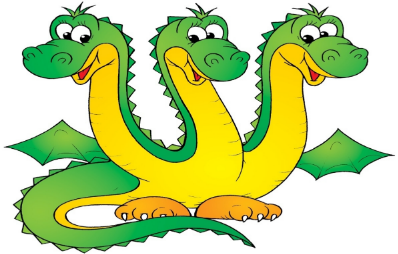

**Регуляризация**

Оптимизируется функционал
$$\sum_{i=1}^n \bigg[  \big( Q_\theta(T_i, X_i) - Y_i \big)^2 + \alpha BCE \big(g_\theta(X_i), T_i\big) + \beta \cdot \gamma_{\theta\varepsilon}(Y_i, T_i, X_i)\bigg] \to \min_{\theta,\ \varepsilon},$$
где
$$\gamma_{\theta\varepsilon}(Y_i, T_i, X_i) = \left( Y_i - \widetilde{Q}_{\theta\varepsilon}(T_i, X_i) \right)^2,$$


$$\widetilde{Q}_{\theta\varepsilon}(t, x) = Q_\theta(t, x) + \varepsilon \bigg[ \frac{t}{g_\theta(x)} - \frac{1-t}{1-g_\theta(x)} \bigg],$$

* $\theta$ &mdash; обучаемые веса сети,
* $\varepsilon$ &mdash; обучаемый параметр,
* $\alpha > 0, \beta \geqslant 0$ &mdash; гиперпараметры модели.

Обучив сеть, можно сделать оценку CATE
$$\widehat{\tau}(x) = \widetilde{Q}_{\widehat{\theta}\widehat{\varepsilon}}(1, x) - \widetilde{Q}_{\widehat{\theta}\widehat{\varepsilon}}(0, x).$$

Кроме того, если $\beta>0$, то есть регуляризация выполняется, то оценка ATE вида
$$\widehat{ATE} = \frac{1}{n} \sum_{i=1}^n \widehat{\tau}(X_i) = \frac{1}{n} \sum_{i=1}^n \left( \widetilde{Q}_{\widehat{\theta}\widehat{\varepsilon}}(1, X_i) - \widetilde{Q}_{\widehat{\theta}\widehat{\varepsilon}}(0, X_i) \right)$$
является оценкой с двойной надежностью. В частности, эта оценка имеет наименьшую асимптотическую дисперсию среди всех асимптотически нормальных оценок если оценки $Q_{\theta\varepsilon}$ и $\gamma_{\theta\varepsilon}$ являются асимптотически нормальными даже с очень большой асимптотической дисперсией.

## 3.4 Balancing Covariates Automatically Using Self-Supervision (BCAUSS)

<a href="https://paperswithcode.com/paper/learning-end-to-end-patient-representations">Статья</a> (2023)

<a href="https://paperswithcode.com/sota/causal-inference-on-ihdp">IHDP Benchmark</a>: **1 место** по точности среди моделей оценки ATE (апрель 2025).


Архитектура сети полностью аналогична DragonNet
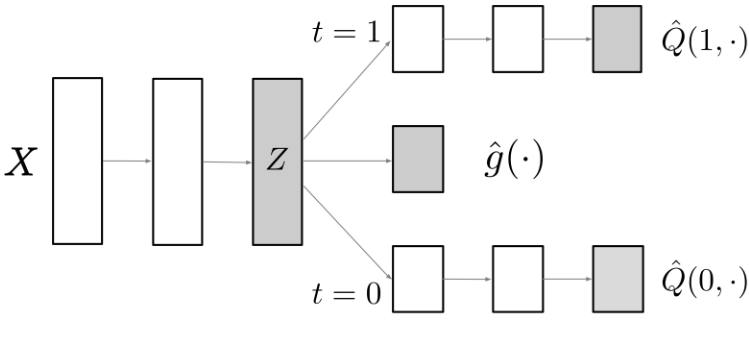


**Условие положительности в DragonNet:**
для любого $X_i$ выполнено
$0 < \mathsf{P}(T = 1 | X) < 1$. То есть любой объект с положительной вероятностью может попать как в одну группу, так и в другую группу. Обычно также требуется более сильное условие пересечения гистограмм propensity score, для выполнения которого не редко нужно выполнять тримминг.

В модели BCAUSS такое условие не требуется.

Оптимизируемый функционал похож на модель DragonNet, но бинарная кросс-энтропия заменяется на другой функционал
$$\sum_{i=1}^n  \big( Q_\theta(T_i, X_i) - Y_i \big)^2 + \alpha L_{bal} \big(g_\theta, T, X\big) \to \min_\theta,$$

Слагаемое с автоматической балансировкой и самоконтролем

$${\large L_{bal}\big(g_\theta, T, X\big) = \frac{1}{d} \sum_{j=1}^d \left(  \frac{\sum\limits_{i=1}^n  \frac{T_i X_{ij}}{g_\theta(X_i)}  }{\sum\limits_{i=1}^n  \frac{T_i}{g_\theta(X_i)}}  -  \frac{\sum\limits_{i=1}^n  \frac{(1-T_i) X_{ij}}{1-g_\theta(X_i)}  }{\sum\limits_{i=1}^n  \frac{1-T_i}{1-g_\theta(X_i)}}  \right)^2}$$

где $g(x)$ &mdash; balancing score.

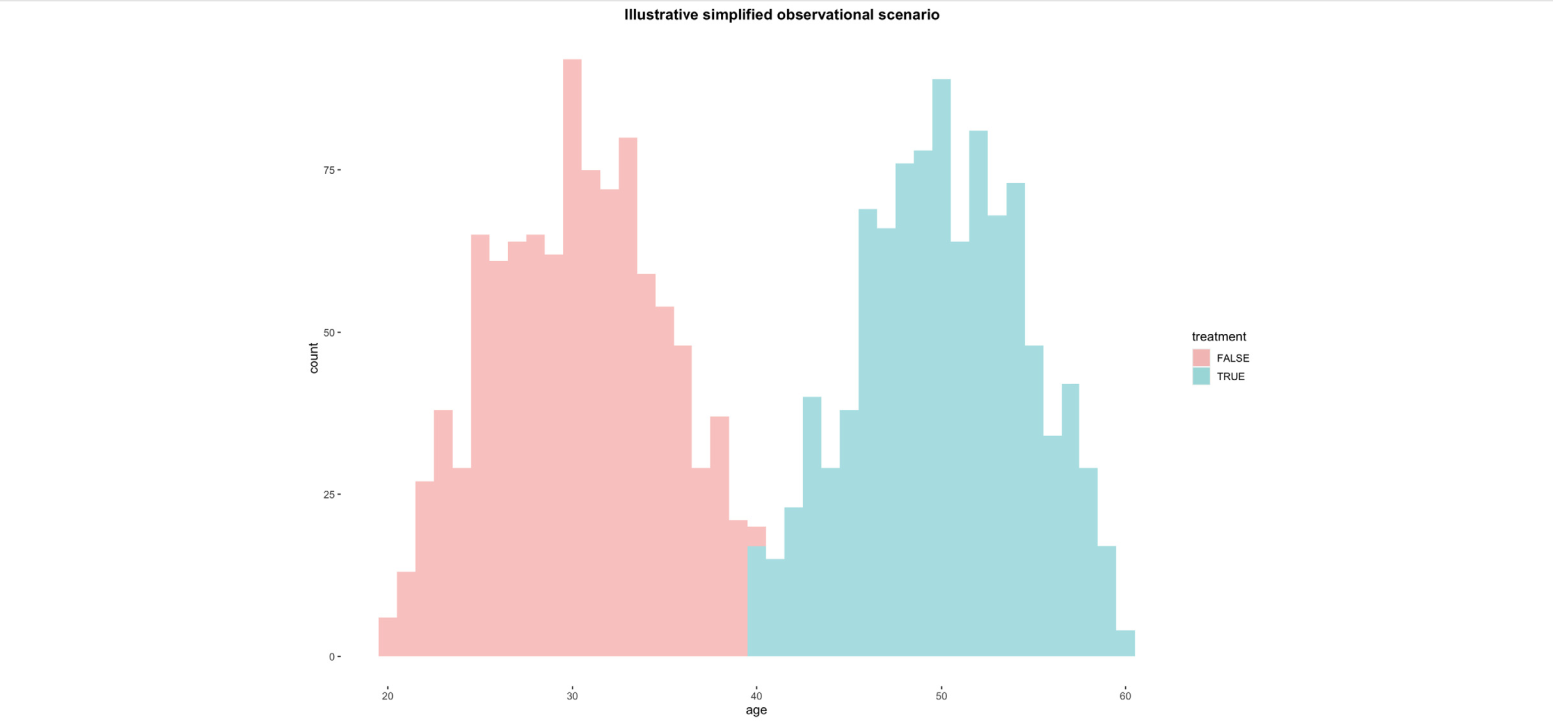

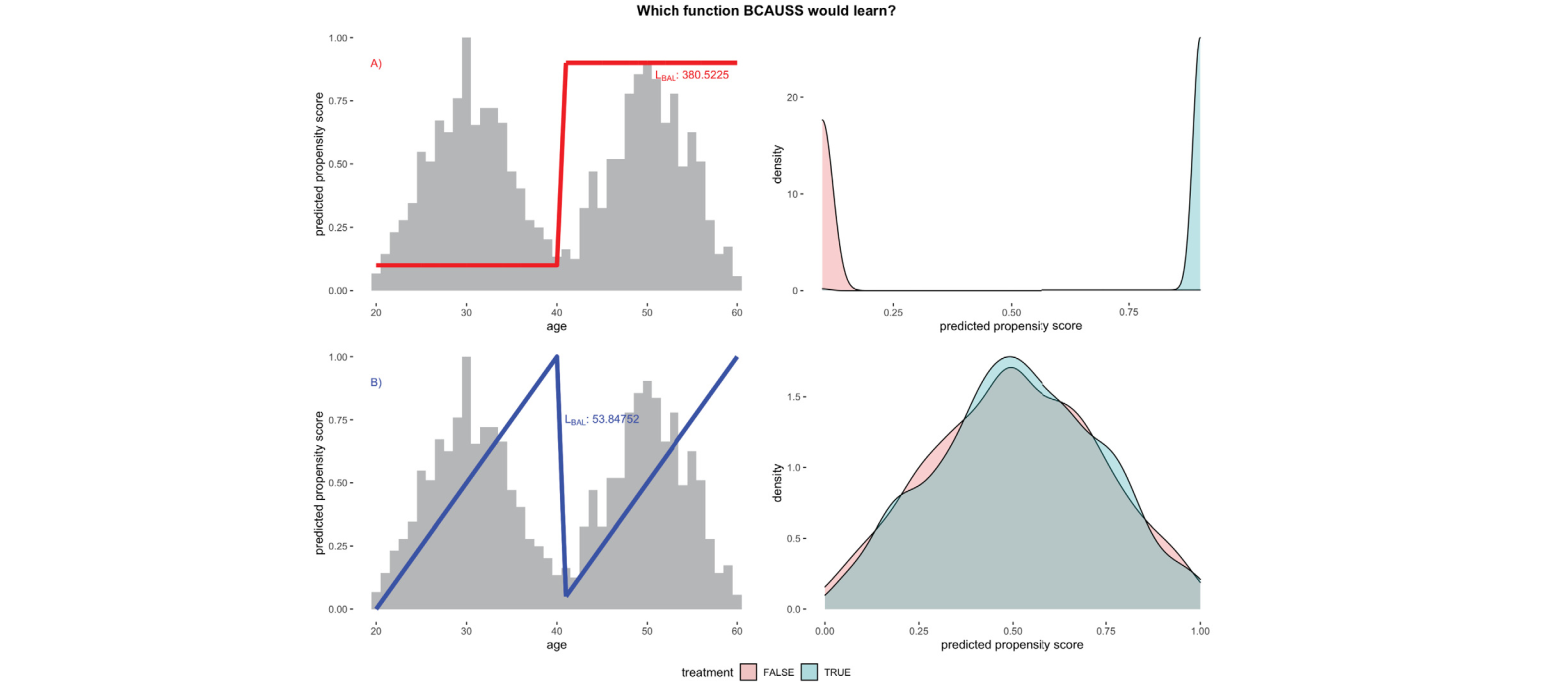